# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 3 (Network)*

---

**Points:** 25<br>
**Due:** 16.11.2022, 10 am<br>
**Contact:** Matthias Fulde ([fulde@cs.uni-frankfurt.de](mailto:fulde@cs.uni-frankfurt.de))<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

<br>

## Table of Contents

---

- [1 Loss](#1-Loss)
- [2 Optimization](#2-Optimization-(5-Points))
  - [2.1 Gradient Descent with Momentum](#2.1-Gradient-Descent-with-Momentum-(3-Points))
  - [2.2 Weight Decay](#2.2-Weight-Decay-(2-Points))
- [3 Deep Neural Network](#3-Deep-Neural-Network-(20-Points))
  - [3.1 Definition](#3.1-Definition-(5-Points))
  - [3.2 Training](#3.2-Training-(15-Points))


<br>

## Setup

---

Besides the NumPy and Matplotlib libraries, we import the definitions of the network layers and the corresponding test cases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from modules import *
from utils import *

%load_ext autoreload
%autoreload 2

<br>

## Exercises

---

### 1 Loss

---

In this assignment we want to create and train a deep neural network for classification, hence we need a loss function. We want to use again the cross-entropy loss that we already implemented in the last assignment.

<br>

#### 1.1 Task

Complete the definition of the `CrossEntropyLoss` class in the `modules/loss.py` file.

Feel free to use the implementation shown in the solution for last week's assignment, but you can also copy your own solution. This exercise is not graded. If you have not implemented this loss in the previous assignment, we highly recommend that you try this yourself before using the given solution.

In the `forward` method of the class, compute the cross-entropy loss and store the result in the `out` variable that is returned from the method. Also cache the labels and the softmax probabilities to reuse them in the backward pass for gradient computation.

In the `backward` method compute the gradient of the loss with respect to the inputs. Store the gradient in the `in_grad` variable that is passed to the given model and that is returned from the method.

Use only vectorized operations.

<br>

#### 1.2 Test

To test the implementation you can run the following cell.

In [2]:
CrossEntropyLoss_test()

True

<br>

### 2 Optimization (5 Points)

---

So far we have only used vanilla gradient descent. That is, the update rule was to scale the gradient with the learning rate and subtract the result from the parameters. In this exercise we want to extend that concept a bit, taking into account also the previous updates.

<br>

### 2.1 Gradient Descent with Momentum (3 Points)

---

One of the problems with standard gradient descent is that the gradient with respect to a parameter may change rapidly during training. These oscillations of the gradient make optimization hard. In addition, there is also the problem of the gradient being stuck in a flat region, where the slope is almost zero. Gradient descent with momentum is one approach to tackle these problems.

Instead of just updating the parameters with

$$
    W^{(t)} = W^{(t-1)} - \eta\nabla\mathcal{L}\left(W^{(t-1)}\right)
$$

<br>

where $\eta$ is the learning rate, we also take into account the previous updates of the parameters, scaled by a hyperparameter called momentum. Thus the update rule becomes

<br>

$$
    W^{(t)} = W^{(t-1)} - V^{(t)}
$$

with

$$
    V^{(t)} = \mu V^{(t-1)} + \eta\nabla\mathcal{L}\left(W^{(t-1)}\right)
$$

<br>

where $V$ is called velocity and $\mu$ is the momentum. The velocity is an array with the same shape as $W$ and $\nabla\mathcal{L}(W)$ and can be understood as a moving average over the past gradients. With this update rule we get a more stable trajectory towards a minimum and we can still move, even if the gradient for the current time step becomes small.

<br>

#### 2.1.1 Task

Complete the definition of the `SGD` class in the `modules/optim.py` file.

In the `step` method of the optimizer, implement the update rule described above. The $\text{learning_rate}$ and $\text{momentum}$ are stored as attributes of the optimizer object and each layer that is iterated over has dictionaries for parameters, gradients and velocity, where corresponding entries are referenced with the same name, given that you adhered to this convention in the previous exercises.

Your implementation should be fully vectorized, so no loops are allowed.

<br>

#### 2.1.2 Test

To test your implementation, run the following code cell.

In [3]:
SGD_test()

True

<br>

### 2.2 Weight Decay (2 Points)

---

In the last assignment, we used L2 regularization to regularize our linear classifier models, computing the squared Euclidean norm of the parameters. We added explicitly a regularization loss term to the data loss term to compute the final loss. However, we can also implement this in a slightly different way.

Instead of computing an explicit loss, we can apply **weight decay**, by just adding the gradient of the L2 regularization loss separately for each parameter to the gradient of the data loss. Hence, for vanilla gradient descent with weight decay we compute

<br>

$$
    W^{(t)} = W^{(t-1)} - \eta\left(\nabla\mathcal{L}\left(W^{(t-1)}\right) + \lambda W^{(t-1)}\right),
$$

<br>

where $\eta$ is the learning rate and $\lambda$ is the regularization strength. This is based on the equivalent definition of the regularization loss as

<br>

$$
    R(W) = \frac{\lambda}{2}\lVert W \rVert^2.
$$

such that

$$
    \frac{\partial}{\partial W} R(W) = \lambda W.
$$

<br>

In the same way we can compute the update when using stochastic gradient descent with momentum. In this case we compute

<br>

$$
    W^{(t)} = W^{(t-1)} - V^{(t)}
$$

with

$$
    V^{(t)} = \mu V^{(t-1)} + \eta\left(\nabla\mathcal{L}\left(W^{(t-1)}\right) + \lambda W^{(t-1)}\right).
$$

<br>

#### 2.2.1 Task

Extend the definition of the `SGD` class in the `modules/optim.py` file.

Add weight decay to the update rule of stochastic gradient descent with momentum, which you implemented in the previous exercise.

Use only vectorized operations.

<br>

#### 2.2.2 Test

To test your implementation, run the following code cell.

In [4]:
SGD_test(use_weight_decay=True)

True

<br>

### 3 Deep Neural Network (20 Points)

---

Now that we have all the components implemented, we can plug everything together to create a deep neural network.

Since we don't have GPU support, we're going to create a rather shallow model. Otherwise the training would take too much time. In order to get an idea how many parameters our model will have in the end, we'll calculate them from hand after the definition.

<br>

### 3.1 Definition (5 Points)

To test our implementations, we're going to define a network with two convolutional layers, each followed by a ReLU activation function and a max pooling layer. We convert the outputs of the last pooling layer into vectors and pass them into a small fully-connected network, composed of two linear layers, the first of which has a ReLU activation function. The last linear layer has no activation function and produces the scores for the ten classes of the dataset.

For both convolutional layers we use a kernel size of 3 and set padding and stride to 1. The first conv layer has 3 input channels and 6 output channels. The second conv layer has 6 input channels and 8 output channels.

For the pooling layers we use a kernel size of 2 and a stride of the same size, so that we pool non-overlapping windows of the feature maps.

The number of output features for the first linear layer should be 32, and for the second linear layer it should be 10, matching the number of classes in the CIFAR-10 dataset that we use again in this exercise.

<br>

#### 3.1.1 Feature Size (1 Point)

The resolution of the images in the CIFAR-10 dataset is $32\times32$. Given the definitions above, compute the number of input features for the first linear layer. Write down all the steps of your computation.

##### Answer

*Write your answer here.*

The first convolution layer receives images of shape 32x32 = 1024 and 3 channels, which means that this layer in total has 3x1024 = 3072 features. It uses a convolution kernel of shape 3x3 which means that the output feature maps would have a width and height of 32-3+1=30 pixels if we would not apply padding to the image. As we padding of size one to the image the convolution layer will produce feature maps of shape 32x32. As there are six channels produces by the convolution layer there are 32x32x6=6144 features calculated.

The pooling layer reduces the shape of each channel by half in each dimension, so there are 6144 * 0.5^2 = 1536 features that the pooling layer will output. These features are spread equally over the six channels, so each channel will have 1536 / 6 = 256 features. Each feature map is of shape 16x16

Now the six feature maps are passed through teh next convolutional layer. This layer will produce eight channels. Because this layer also pads each feature map with one pixel for each border the resulting feature maps will have 16x16 pixels. 

The eight feature maps are again passed through a pooling layer which again reduces the shape of the feature maps by half for each dimension. The resulting feature maps will be of shape 8x8. As we have eight feature maps the pooling layer outputs 8x8x8 = 512 features.

These 512 features are then passed to the first linear layer.

<br>

#### 3.1.2 Implementation (2 Points)

Complete the definition of the `ConvNet` class below.

If you don't define the `forward` method, the inherited method from the base class will call the layers in the order in which they were added as attributes in the constructor. You don't have to define a `backward` method.

Create the network according to the above definitions.

In [5]:
class ConvNet(Module):

    def __init__(self):
        """
        Create deep neural network with two conv and two linear layers.
        """
        super().__init__()
        ############################################################
        ###                  START OF YOUR CODE                  ###
        ############################################################

        # First block of convolution, activation and pooling layers
        self.convolution1 = Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1, stride=1)
        self.activation1 = ReLU()
        self.pooling1 = MaxPool(kernel_size=2, stride=2)
        
        # Second block of convolution, activation and pooling layers
        self.convolution2 = Conv2d(in_channels=6, out_channels=8, kernel_size=3, padding=1, stride=1)
        self.activation2 = ReLU()
        self.pooling2 = MaxPool(kernel_size=2, stride=2)
        
        self.vectorize = Vector()
        self.linear1 = Linear(in_features=512, out_features=32)
        self.activation3= ReLU()
        self.linear2 = Linear(in_features=32, out_features=10)

        ############################################################
        ###                   END OF YOUR CODE                   ###
        ############################################################

<br>

#### 3.1.3 Capacity (2 Points)

Now we want to compute the capacity of the model, which is the number of learnable parameters. Compute the number of parameters for each layer and than sum the results to get the total number of parameters of the model.

##### Answer

*Write your answer here.*

| layer        | params |
|--------------|--------|
| convolution1 | (3x3x3+1)x6 = 168     |
| pooling1     | 0      |
| activation1  | 0      |
| convolution2 | (3x3x3+1)x8 = 224     |
| pooling2     | 0      |
| activation2  | 0      |
| linear1  | (512+1)x32 = 16416      |
| activation3  | 0      |
| linear2  | (32+1)x10 = 330      |

The convolutional layers have 3x3x3+1 parameters per channel. 3x3x3 is the kernel size plus one for the bias.

The pooling layer has no parameters and so does the activation layer.

The first linear layer takes 512 features plus the bias and is fully connected to the next layer which has 32 features. So the linear layer has (512+1)x32 parameters.

The final linear layer maps 32 features plus the bias to the ten output categories. This layer has (32+1)x10 parameters.

In total the model has 17138 parameters.

<br>

### 3.2 Training (15 Points)

---

We want to train our model again on the CIFAR-10 dataset that we already used in the previous problem sets. The function for loading and preprocessing the data expects the dataset in the `datasets` folder in the same directory as the notebook, so copy the folder before you proceed.

Let's load the data and print the shapes.

In [6]:
# Load and preprocess the CIFAR-10 dataset.
data = get_CIFAR_10_data()

# Output the shapes of the partitioned data and labels.
for name, array in data.items():
    print(f'{name} shape: {array.shape}')

X_train shape: (49000, 3, 32, 32)
y_train shape: (49000,)
X_test shape: (1000, 3, 32, 32)
y_test shape: (1000,)
X_val shape: (1000, 3, 32, 32)
y_val shape: (1000,)
X_dev shape: (500, 3, 32, 32)
y_dev shape: (500,)


<br>

#### 3.2.1 Task (12 Points)

Implement a training loop for the defined model and dataset.

In each iteration, randomly sample a minibatch of $64$ images from the development set with replacement. Compute the forward pass through the network. In order to do this, you can call the model directly. The `__call__` method dispatches to the `forward` method of the instance.

Compute the average accuracy for the training batch and store it in the predefined `train_acc` list.

The next step is to call the loss function with the model output and the ground truth labels. Again, you can call the instance directly. Store the loss in the `train_loss` list that is already defined. After that, call the `backward` method of the loss to compute the gradients of the loss with respect to the model parameters.

In order to update the parameters, call the `step` method of the optimizer.

Finally, sample a minibatch of the same size from the validation set and compute a forward pass. Again compute the loss. Store it in the `val_loss` list. Compute the average accuracy of the predictions and store the result in the `val_acc` list.

Use only vectorized operations. No further loops are allowed.

<br>

You're model should at least converge, so the loss should decrease and the accuracy increase. With the given settings, expect a slow start, but towards the end of the given number of iterations, you should see that the accuracy on the development set is well above chance, which would be $10\%$.

Since we're training only on the CPU, be prepared that training the model with the predefined settings may take a while!

<br>

#### 3.2.2 Solution

Write your solution in the marked code cell below.

In [7]:
# Create the model.
model = ConvNet()

# Create the loss function.
loss = CrossEntropyLoss(model)

# Create the optimizer.
optimizer = SGD(model, lr=1e-3, momentum=0.9, weight_decay=5e-4)

# Access development set.
X_dev = data['X_dev']
y_dev = data['y_dev']

# Access validation set.
X_val = data['X_val']
y_val = data['y_val']

In [8]:
# Lists to store training and validation loss.
train_loss = []
val_loss = []

# Lists to store the training and validation accuracy.
train_acc = []
val_acc = []

In [9]:
# Set number of iterations.
num_iter = 100

# Set number of samples per minibatch.
batch_size = 64

# Show intermediate results.
verbose = True
print_every = 10

# Train the model.
for i in range(1, 1+num_iter):
    ############################################################
    ###                  START OF YOUR CODE                  ###
    ############################################################
    
    training, validation = [
        (X_dev, y_dev, train_acc, train_loss, False),
        (X_val, y_val, val_acc, val_loss, True)
    ]
    
    # Iterate over training and validation batches
    for (X, y, batch_acc, batch_loss, freeze) in [training, validation]:
        # Sample mini batch
        rand_idx = np.random.choice(X_dev.shape[0], batch_size, replace=True)
        X_batch = X[rand_idx]
        y_batch = y[rand_idx]

        # Pass batch through the model
        result = model(X_batch)
    
        # Compute predictions of the model and the accuracy
        predictions = np.argmax(result, axis=1)
        accuracy = (y_batch == predictions).sum() / len(predictions)
    
        # Store accuracy
        batch_acc.append(accuracy)

        # Compute and store loss
        batch_loss.append(loss.forward(result, y_batch))

        if not freeze:
            # call the backward method of the loss to compute the gradients of the loss
            grad = loss.backward()

            # Update parameters
            optimizer.step()

    ############################################################
    ###                   END OF YOUR CODE                   ###
    ############################################################
    if verbose and (i == 1 or i % print_every == 0):
        print(
            f'Iter: {i:4}  | ',
            f'Train acc: {train_acc[-1]*100:6.2f}%  | ',
            f'Val acc: {val_acc[-1]*100:6.2f}%  | ',
            f'Train loss: {train_loss[-1]:6.3f}  | ',
            f'Val loss: {val_loss[-1]:6.3f}'
        )

Iter:    1  |  Train acc:   4.69%  |  Val acc:   6.25%  |  Train loss:  6.304  |  Val loss:  3.372
Iter:   10  |  Train acc:  15.62%  |  Val acc:  12.50%  |  Train loss:  2.324  |  Val loss:  2.306
Iter:   20  |  Train acc:  20.31%  |  Val acc:  14.06%  |  Train loss:  2.213  |  Val loss:  2.282
Iter:   30  |  Train acc:  28.12%  |  Val acc:  15.62%  |  Train loss:  2.166  |  Val loss:  2.254
Iter:   40  |  Train acc:  23.44%  |  Val acc:  21.88%  |  Train loss:  2.153  |  Val loss:  2.256
Iter:   50  |  Train acc:  21.88%  |  Val acc:  21.88%  |  Train loss:  2.232  |  Val loss:  2.195
Iter:   60  |  Train acc:  17.19%  |  Val acc:  15.62%  |  Train loss:  2.119  |  Val loss:  2.143
Iter:   70  |  Train acc:  23.44%  |  Val acc:  18.75%  |  Train loss:  2.028  |  Val loss:  2.157
Iter:   80  |  Train acc:  17.19%  |  Val acc:  25.00%  |  Train loss:  2.033  |  Val loss:  1.949
Iter:   90  |  Train acc:  25.00%  |  Val acc:  20.31%  |  Train loss:  2.088  |  Val loss:  2.062
Iter:  100

<br>

#### 3.2.3 Results

Let's check the best accuracy on the training and validation set.

In [10]:
print(f'Best train acc: {np.max(train_acc)*100:6.2f}  |  Best val acc: {np.max(val_acc)*100:6.2f}')

Best train acc:  42.19  |  Best val acc:  31.25


Let's also plot the training and validation losses and accuracies obtained during training.

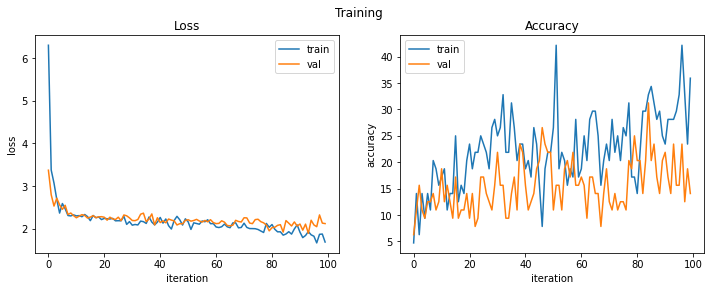

In [11]:
show_training(train_loss, val_loss, train_acc, val_acc)

<br>

#### 3.2.4 Observations (3 Points)

Briefly describe your observations when you trained the model.

##### Answer

*Write your answer here.*

We can see that the convolutional model performs better than the linear model in the previous exercise. But the predictions are far away from being good. For better results we either need more training time or a more complex model.
We also see some overfitting on the training data. The model achieves around 42% accurac